# Bone Segmentation for CT Scan #

### Author: Angelo Antonio Manzatto ###

-------------------------------------
### Problem ###

Image segmentation is a tedious, difficult but no less important initial step for medical analysis and diagnosis. 

This project focus on extracting the bones in CT scans in order to speed up the tasks executed by people involved in the medical field.

![Bone Segmentation](images/bone_segmentation.jpg)

-------------------------------------
### Task ###

Develop a complete solution using Convolutional Neural Networks to extract the bones from a series of CT (Computed Tomography)

The following pipeline was adopted for this project:

* Download and process selected database from IRCAD.
* Create dataset.
* Create data augmentations techniques for pre processing steps.
* Create model (Unet)
* Train model.
* Evaluate model.
* Test a batch of samples not previously seen by the model.
* Test the model against a completly different database (VOXEL-MAN)

-------------------------------------
### Model ###

For this project I used a Unet model that act's as an encoder-decoder process. The model used here is a simpler version than the proposed one on the origianl paper (https://arxiv.org/pdf/1505.04597.pdf) since it starts with 32 channels output instead of 64 decreasing to 512 instead of 1024. 

![Resnet Model](images/unet.jpg)

-------------------------------------
### Results ###

Here is the final result of the applied trained model on a validation set.

![Hamburg University SIO Database](images/bone_segmentation.gif)

-------------------------------------

This project was made using the IRCAD database

Reference: https://www.ircad.fr/research/3d-ircadb-01/
3D IRCAD - Hôpitaux Universitaires

VOXEL-Man:
https://www.voxel-man.com/segmented-inner-organs-of-the-visible-human/

In [1]:
##################################################################################
# Libraries
##################################################################################  
import os
import requests
import io
import random
import glob
import zipfile
import shutil 
import csv
import pydicom

import numpy as np

import matplotlib.pyplot as plt

import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model

from keras.layers import Input,Activation
from keras.layers import Conv2D,  MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate

from keras.callbacks import ModelCheckpoint, CSVLogger

import keras.backend as K

from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
##################################################################################
# Download Dataset
##################################################################################  
'''
This method is responsable for downloading and processing all the IRCAD datasets needed to train our model and
should be executed only once.

'''
def process_ircad_database(database_url, inputs_folder, bone_masks_folder, overwrite=False):
    
    # Database name will be assumed as the name on the last "/" before the ".zip"
    database_name = database_url.split('/')[-1].split(".zip")[0]
    
    print(50*'-')
    print("Processing: {0}".format(database_name))
    print(50*'-')
    
    # Download the dataset if doesn't exist and extract to appropriate folder
    database_folder = os.path.join(dataset_folder,database_name)
    
    if not os.path.exists(database_folder):
        os.makedirs(database_folder)
    
    # Request files
    r = requests.get(database_url)
    
    print("Request status code: {0}".format(r.status_code))
    
    z = zipfile.ZipFile(io.BytesIO(r.content))
    
    r.close()

    print("Database downloaded")
    print(50*'-')
    
    # Extract data to folder
    z.extractall(dataset_folder)
    z.close()
    
    print("Files extracted")
    print(50*'-')
    
    # Unzip Laled dicom
    label_dicom_zip_file = os.path.join(database_folder,'PATIENT_DICOM.zip')
    label_dicom_zip = zipfile.ZipFile(label_dicom_zip_file)
    label_dicom_zip.extractall(database_folder)
    label_dicom_zip.close()
    
    # Unzip masks dicom
    mask_dicom_zip_file = os.path.join(database_folder,'MASKS_DICOM.zip')
    mask_dicom_zip = zipfile.ZipFile(mask_dicom_zip_file)
    mask_dicom_zip.extractall(database_folder)
    mask_dicom_zip.close()
    
    print("Label and Masks extracted")
    print(50*'-')
    
    # Folders form input and bone masks dicom
    label_dicom_folder = os.path.join(database_folder,'PATIENT_DICOM') 
    bone_mask_dicom_folder = os.path.join(database_folder,'MASKS_DICOM','bone') 
    
    # Select all input and mask dicom files
    label_dicom_paths = glob.glob(os.path.join(label_dicom_folder,'*')) 
    bone_mask_dicom_paths = glob.glob(os.path.join(bone_mask_dicom_folder,'*')) 
    
    n_label = len(label_dicom_paths)
    n_bone_masks = len(bone_mask_dicom_paths) 
    print("Label files: {0}".format(n_label))
    print("Bone mask files: {0}".format(n_bone_masks))
    print(50*'-')
    # Check if we have files and both input and mask folder have the same number of files
    assert(len(label_dicom_paths) == len(bone_mask_dicom_paths) and len(label_dicom_paths) > 0 and len(bone_mask_dicom_paths) > 0)

    # Move files to appropriate folder

    current_index = 1
    
    # Update the current_index with the last file index on the folder
    if(overwrite == False):
        
        input_dicom_paths = glob.glob(os.path.join(inputs_folder,'*.dcm'))
        
        if(len(input_dicom_paths) == 0):
            current_index = 1
        else:
            # Grab the file names and extract just the number so input00012.dicom -> 12
            indices = [int(x.split("\\")[-1][5:10])  for x in input_dicom_paths]
            indices.sort()
            last_index = indices[-1]
            
            current_index = last_index + 1
    
    print("Moving files starting with index: {0}".format(current_index))
    print(50*'-')     
    
    for label_dicom_path, bone_mask_dicom_path in zip(label_dicom_paths, bone_mask_dicom_paths):
    
        assert(label_dicom_path.split("\\")[-1] == bone_mask_dicom_path.split("\\")[-1])
        
        new_input_dicom_path = os.path.join(inputs_folder,'input' + str(current_index).zfill(5) + ".dcm")
        new_bone_mask_dicom_path = os.path.join(bone_masks_folder,'mask' + str(current_index).zfill(5) + ".dcm")
        
        shutil.copy(label_dicom_path, new_input_dicom_path)
        shutil.copy(bone_mask_dicom_path, new_bone_mask_dicom_path)
        
        current_index +=1
    
    print("Moving process complete")
    print(50*'-')    
    
    # Delete temporaty database folder after we exctracted files we wantes
    shutil.rmtree(database_folder)
    
    print("Database folder excluded")
    print(50*'-')  
            
dataset_folder = 'dataset'

inputs_folder = os.path.join(dataset_folder,'inputs')
bone_masks_folder = os.path.join(dataset_folder,'bone_masks')

database_urls = [
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.1.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.2.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.3.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.4.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.5.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.6.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.7.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.8.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.9.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.10.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.11.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.12.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.13.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.14.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.15.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.16.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.17.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.18.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.19.zip',
                 'https://www.ircad.fr/softwares/3Dircadb/3Dircadb1/3Dircadb1.20.zip',
                 ]

In [4]:
# Create Dataset folder 
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
    
# Create Input DICOM folder 
if not os.path.exists(inputs_folder):
    os.makedirs(inputs_folder)
    
# Create Bone Masks folder
if not os.path.exists(bone_masks_folder):
    os.makedirs(bone_masks_folder)

In [ ]:
# Execute this line ONLY if you want to download and process the dataset
# The request library hangs sometimes after processing the last request. If that happens you have to start the process
# again from the dataset that you have stoped
for database_url in database_urls:
    process_ircad_database(database_url,inputs_folder,bone_masks_folder)

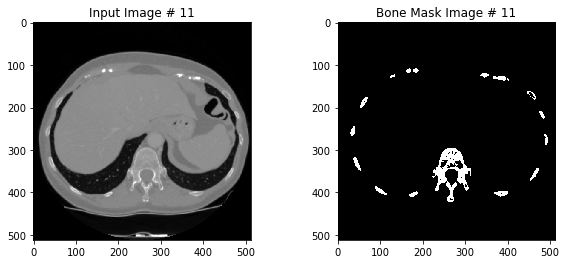

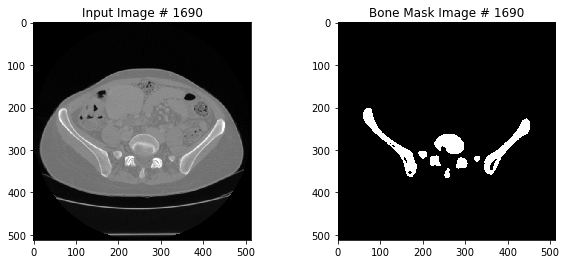

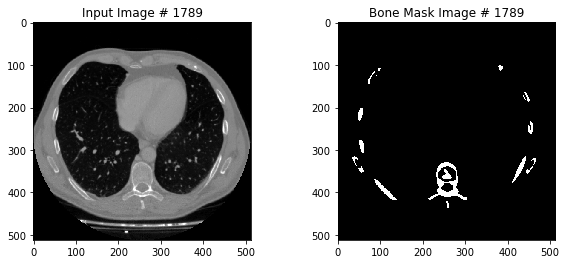

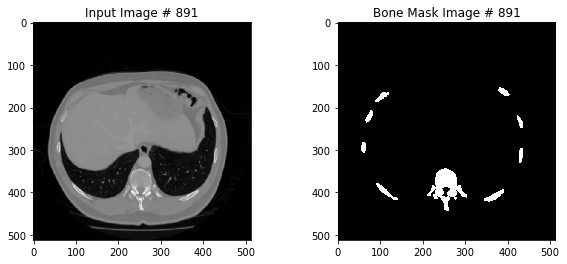

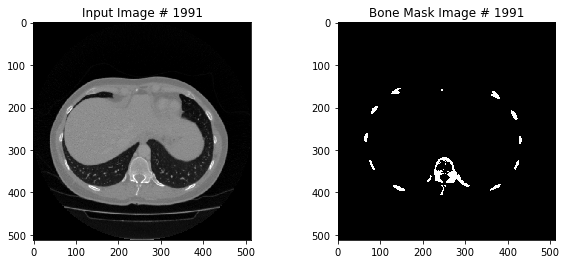

In [5]:
############################################################################################
# Load data
############################################################################################
    
# Load a DICOM file and convert it to [0-255] gray scale    
# For IRC  Dataset minimum value = -2048 and maximum value = 3247
def load_dicom(dicom_path):
    
    # Load dicom file
    dicom = pydicom.read_file(dicom_path)
    
    # Select only pixel image data
    pixel_data = dicom.pixel_array 

    # Normalize data using slope and interceptallow to transform the pixel values to Hounsfield Units    
    intercept = dicom.RescaleIntercept
    slope = dicom.RescaleSlope
    
    pixel_data = pixel_data * slope +intercept 

    image = np.zeros(pixel_data.shape)
    
    # Normalize image from 16 bits int to 8 bits unsigned int (JPG)
    image = (pixel_data + 65535)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image[image > 255] = 255
    image[image < 1] = 0
          
    return image.astype('uint8')

# DICOM image files
input_files = glob.glob(os.path.join(inputs_folder,'*.dcm'))  
bone_mask_files = glob.glob(os.path.join(bone_masks_folder,'*.dcm'))   

# Sort names to avoid connecting wrong numbered files
input_files.sort()
bone_mask_files.sort()

assert(len(input_files) == len(bone_mask_files))

# Our dataset is created using the tuple (input image file, ground truth image file)
data = []
for input_image, bone_mask_image in zip(input_files, bone_mask_files):
    
    data.append((input_image,bone_mask_image))

# Plot some samples from dataset
n_samples = 5

for i in range(n_samples):
    
    # define the size of images
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(10)
    
    # randomly select a sample
    idx = np.random.randint(0, len(data))
    input_image_path, bone_mask_image_path = data[idx]
    
    input_image = load_dicom(input_image_path)
    bone_mask_image = load_dicom(bone_mask_image_path) 
    
    ax1.imshow(input_image, cmap = 'gray')
    ax1.set_title('Input Image # {0}'.format(idx))
    
    ax2.imshow(bone_mask_image, cmap = 'gray')
    ax2.set_title('Bone Mask Image # {0}'.format(idx))

In [7]:
############################################################################################
# Data Augmentation 
############################################################################################
    
#############################
# Resize Image
#############################
class Resize(object):
    
    def __init__(self, input_size, output_size):
        
        assert isinstance(input_size,(int, tuple))
        assert isinstance(output_size,(int, tuple))
        
        self.input_size = input_size
        self.output_size = output_size    
        
    def __call__(self, input_image, mask_image):     
           
        h_in, w_in = input_image.shape[:2]
        h_out, w_out = mask_image.shape[:2]
        
        if isinstance(self.input_size, int):
            if h_in > w_in:
                new_h_in, new_w_in = self.input_size * h_in / w_in, self.input_size
            else:
                new_h_in, new_w_in = self.input_size, self.input_size * w_in / h_in
        else:
            new_h_in, new_w_in = self.input_size
        
        if isinstance(self.output_size, int):
            if h_out > w_out:
                new_h_out, new_w_out = self.output_size * h_out / w_out, self.output_size
            else:
                new_h_out, new_w_out = self.output_size, self.output_size * w_out / h_out
        else:
            new_h_out, new_w_out = self.output_size

        new_h_in, new_w_in = int(new_h_in), int(new_w_in)
        new_h_out, new_w_out = int(new_h_out), int(new_w_out)

        input_image = cv2.resize(input_image, (new_w_in, new_h_in))
        mask_image = cv2.resize(mask_image, (new_w_out, new_h_out)) 
        
        return input_image,  mask_image

#############################
# Translate Image
#############################    
class RandomTranslation(object):

    def __init__(self, ratio = 0.4, background_color = (0) , prob=0.5):
        
        self.background_color  = background_color
        self.ratio = ratio
        self.prob  = prob
        
    def __call__(self, input_image, mask_image):
                
        if random.uniform(0, 1) <= self.prob:
            
            img_h, img_w = input_image.shape
            
            x = int(np.random.uniform(-self.ratio,self.ratio) * img_w)
            y = int(np.random.uniform(-self.ratio,self.ratio) * img_h)

            M = np.float32([[1, 0, x],
                            [0, 1, y]])
                
            input_image_translated = cv2.warpAffine(input_image,M,(img_w,img_h), borderValue=self.background_color)
            imask_image_translated = cv2.warpAffine(mask_image,M,(img_w,img_h), borderValue=self.background_color)
            
            return input_image_translated , imask_image_translated
           
        return input_image, mask_image

#############################
# Scale Image
#############################  
class RandomScale(object):

    def __init__(self, lower = 0.4, upper = 1.4, background_color = (0) , prob=0.5):
        
        self.background_color = background_color
        self.lower = lower
        self.upper = upper
        self.prob  = prob  
        
    def __call__(self, input_image, mask_image):
                
        if random.uniform(0, 1) <= self.prob:
            
            input_img_h, input_img_w = input_image.shape
            mask_img_h, mask_img_w = mask_image.shape
            
             # Create canvas with random ration between lower and upper
            ratio = random.uniform(self.lower,self.upper)
            
            scale_x = ratio
            scale_y = ratio
            
            # Scale the image
            scaled_input_image = cv2.resize(input_image.astype('float32'),(0,0),fx=scale_x,fy=scale_y)
            scaled_mask_image = cv2.resize(mask_image.astype('float32'),(0,0),fx=scale_x,fy=scale_y)
            
            top = 0
            left = 0
            
            if ratio < 1:
                    
                # Input image
                background = np.zeros((input_img_h, input_img_w), dtype = np.uint8)
                
                background[:,:] = self.background_color 
            
                y_lim = int(min(scale_x,1)*input_img_h)
                x_lim = int(min(scale_y,1)*input_img_w)
                
                top  = (input_img_h - y_lim) // 2
                left = (input_img_w - x_lim) // 2

                background[top:y_lim+top,left:x_lim+left] = scaled_input_image[:y_lim,:x_lim]
                
                scaled_input_image = background
                
                # Mask image                
                background = np.zeros((mask_img_h, mask_img_w), dtype = np.uint8)
                
                background[:,:] = self.background_color 
                
                y_lim = int(min(scale_x,1)*mask_img_h)
                x_lim = int(min(scale_y,1)*mask_img_w)
                
                top  = (mask_img_h - y_lim) // 2
                left = (mask_img_w - x_lim) // 2
                
                background[top:y_lim+top,left:x_lim+left] = scaled_mask_image[:y_lim,:x_lim]
                
                scaled_mask_image = background
                    
            else:
                
                top  = (scaled_input_image.shape[0] -  input_img_h) // 2
                left = (scaled_input_image.shape[1] -  input_img_w) // 2
                
                scaled_input_image = scaled_input_image[top:input_img_h+top,left:input_img_w+left]
                
                top  = (scaled_mask_image.shape[0] -  mask_img_h) // 2
                left = (scaled_mask_image.shape[1] -  mask_img_w) // 2
                
                scaled_mask_image = scaled_mask_image[top:mask_img_h+top,left:mask_img_w+left]
                         
            return scaled_input_image, scaled_mask_image

        return input_image, mask_image
    
#############################
# Flip image
#############################    
class RandomFlip(object):
 
    def __init__(self, prob=0.5):

        self.prob = prob
        
    def __call__(self, input_image, mask_image):
        
        if random.uniform(0, 1) <= self.prob:
        
            # Get image shape
            h, w = input_image.shape[:2]
            
            # Flip image
            input_image = input_image[:, ::-1]
            
            # Get image shape
            h, w = mask_image.shape[:2]
            
            # Flip image
            mask_image = mask_image[:, ::-1]
            
            # Random flip horizontally
            if random.uniform(0, 1) <= 0.5 :
                
                input_image = np.flip(input_image)
                mask_image = np.flip(mask_image)
            
            return input_image, mask_image
        
        return input_image, mask_image

#############################
# Change image brightness
############################# 
class RandomBrightness():
    
    def __init__(self, lower = -25, upper = 25, prob = 0.5):

        self.lower = lower
        self.upper = upper
        self.prob = prob
    
    def __call__(self, input_image,  mask_image):
        
        if random.uniform(0, 1) <= self.prob:
            
            amount = int(random.uniform(self.lower, self.upper))
            
            input_image = np.clip(input_image + amount, 0, 255).astype("uint8")
        
            return input_image, mask_image
        
        return input_image, mask_image

#############################
# Change image contrast
############################# 
class RandomContrast():
    
    def __init__(self, lower = 0.5, upper = 1.5, prob = 0.5):

        self.lower = lower
        self.upper = upper
        self.prob = prob
    
    def __call__(self, input_image,  mask_image):
        
        if random.uniform(0, 1) <= self.prob:
            
            amount = random.uniform(self.lower, self.upper)
            
            input_image = np.clip(input_image * amount, 0, 255).astype("uint8")
        
            return input_image, mask_image
        
        return input_image, mask_image
    
#############################    
# Gaussian Noise
#############################    
class GaussianNoise(object):
    
    def __init__(self,mean=0.0, var=0.1, prob=0.5):

        self.mean = mean
        self.var = var
        self.prob = prob
    
    def __call__(self, input_image, mask_image):
        
        if random.uniform(0, 1) <= self.prob:
        
             # Get image shape
            h, w = input_image.shape[:2]
            
            sigma = self.var **0.5
            
            gauss = np.random.normal(self.mean,sigma,(w,h))
            gauss = gauss.reshape(w,h)
            
            noise_input_image = input_image + gauss
            
            return noise_input_image, mask_image
        
        return input_image, mask_image


#############################
# Normalize
#############################
class Normalize(object):
    
    """Normalize the color range to [0,1].""" 
       
    def __call__(self, input_image, mask_image):
                    
        return input_image / 255 , mask_image / 255 

############################################################################################
# Test Data Augmentation 
############################################################################################
def plot_transformation(transformation, n_samples = 3, normalize = False):

    for i in range(n_samples):
    
        # define the size of images
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
        f.set_figwidth(14)

        # randomly select a sample
        idx = np.random.randint(0, len(data))
        input_image_path, bone_mask_image_path = data[idx]
    
        input_image = load_dicom(input_image_path)
        bone_mask_image = load_dicom(bone_mask_image_path)
        
        if normalize:
            norm = Normalize()
            input_image, bone_mask_image = norm(input_image, bone_mask_image)

        new_input_image, new_bone_mask_image = transformation(input_image, bone_mask_image)
        
        ax1.imshow(input_image , cmap = 'gray')
        ax1.set_title('Original Input')
        
        ax2.imshow(new_input_image , cmap = 'gray')
        ax2.set_title(type(transformation).__name__)

        ax3.imshow(bone_mask_image , cmap = 'gray')
        ax3.set_title('Original Bone Mask')
        
        ax4.imshow(new_bone_mask_image , cmap = 'gray')
        ax4.set_title(type(transformation).__name__)

        plt.show()

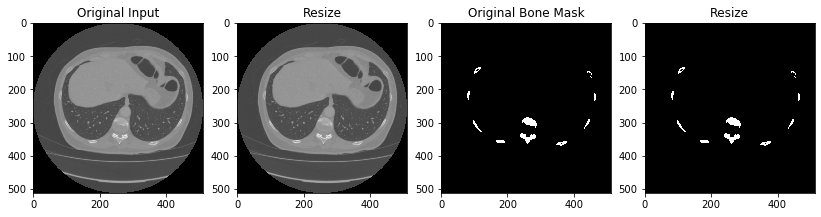

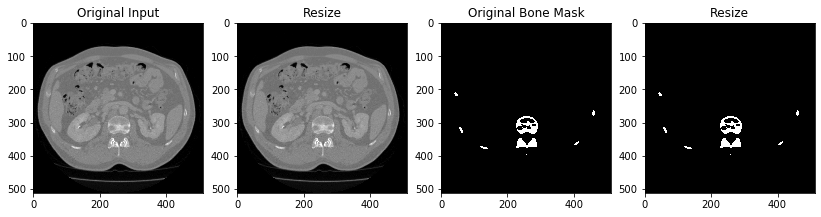

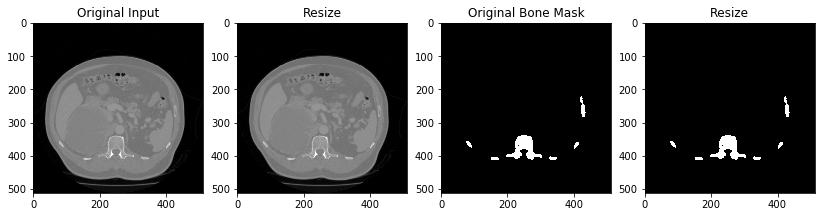

In [8]:
##########################
# Resize Test
##########################
resize = Resize((512, 512),(512, 512))
plot_transformation(resize)

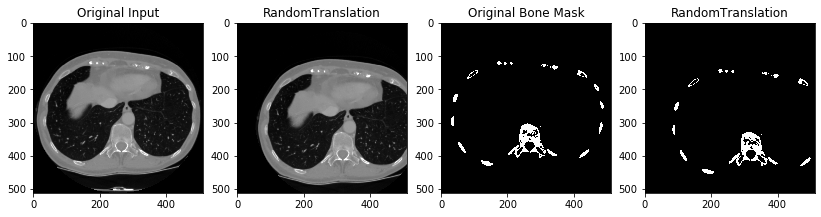

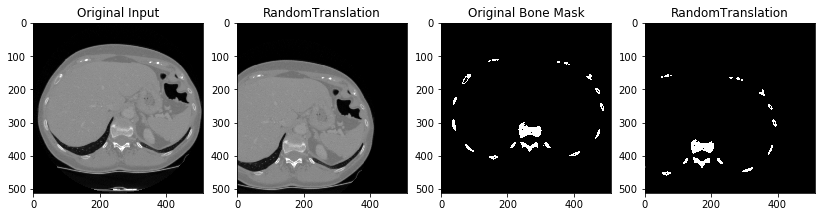

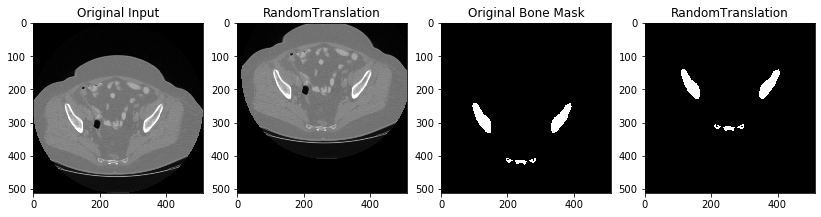

In [9]:
##########################
# Random Translation
##########################
translation = RandomTranslation(ratio = 0.2, prob=1.0)
plot_transformation(translation)

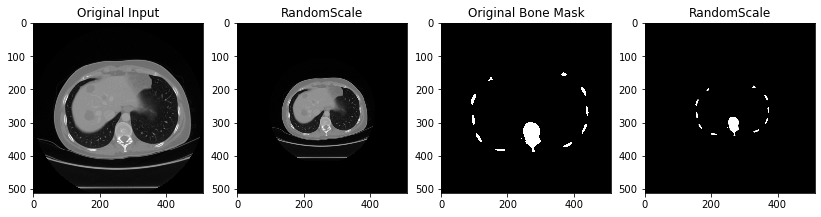

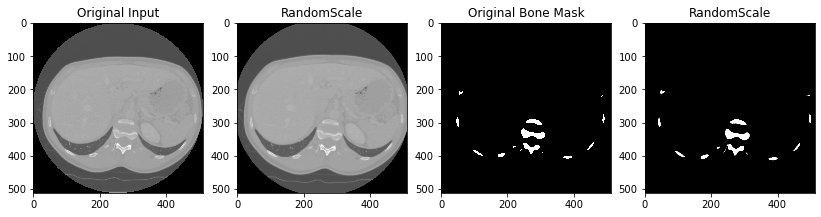

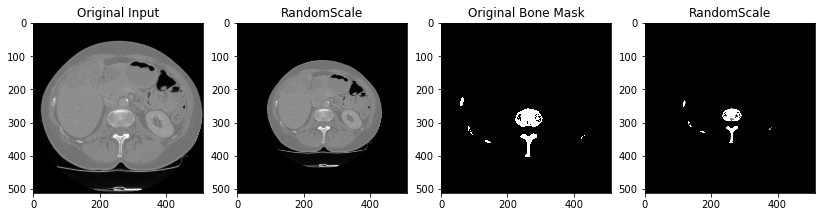

In [10]:
##########################
# Random Scale
##########################
scale = RandomScale(prob=1.0)
plot_transformation(scale)

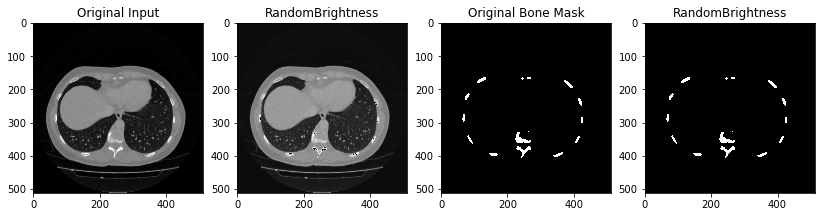

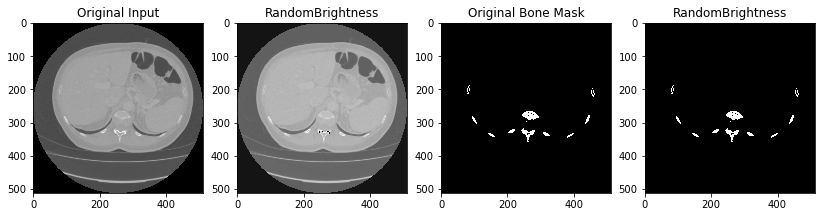

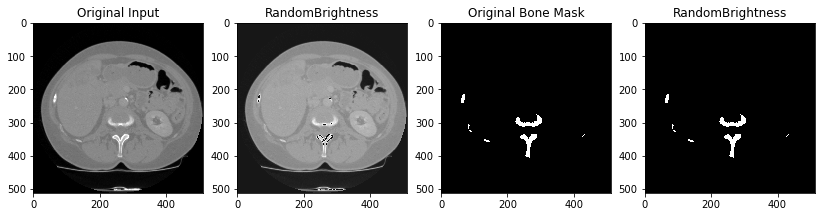

In [11]:
##########################
# Random Brightness Test
##########################
bright = RandomBrightness(prob=1.0)
plot_transformation(bright)

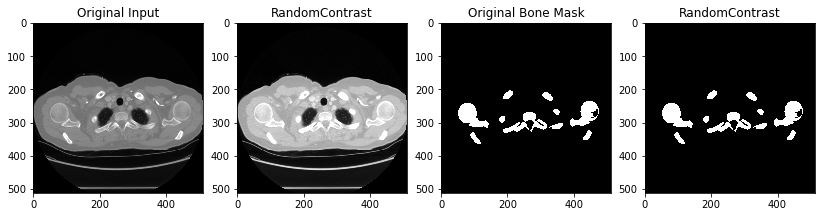

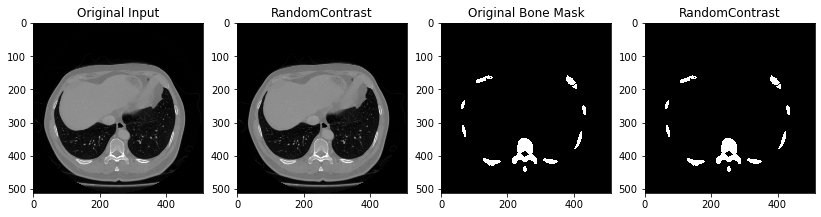

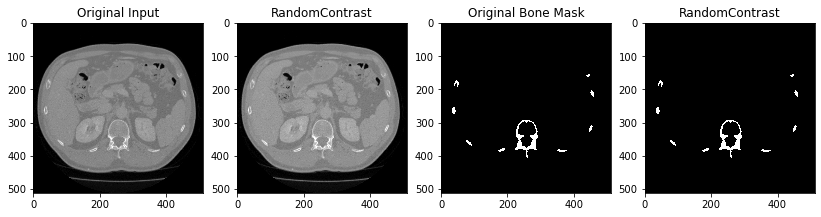

In [12]:
##########################
# Random Contrast Test
##########################
contrast = RandomContrast(prob=1.0)
plot_transformation(contrast)

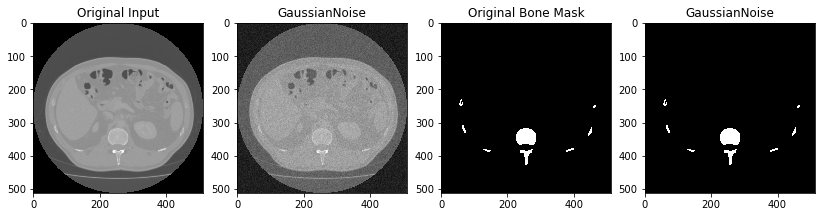

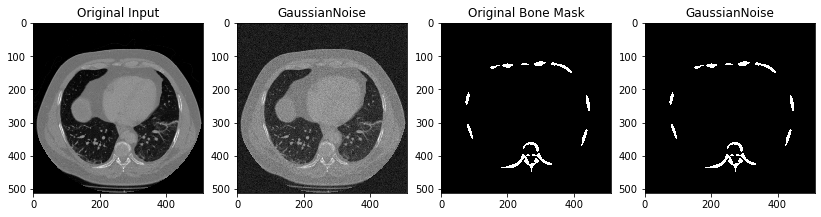

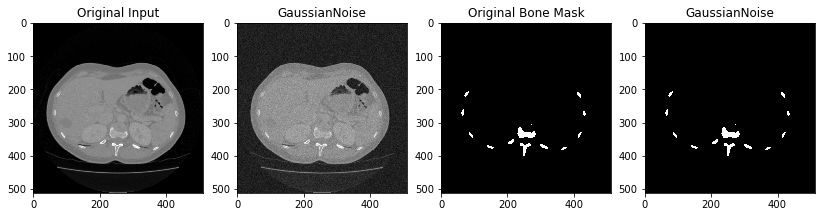

In [13]:
##########################
# Gaussian Noise Test
##########################
noise = GaussianNoise(mean=0.0, var=0.001, prob=1.0)
plot_transformation(noise, normalize = True)

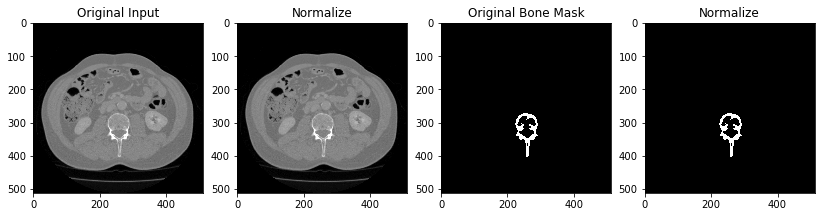

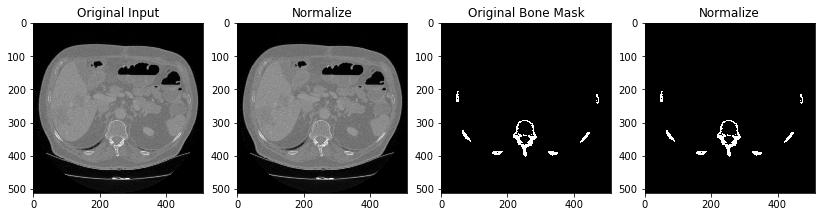

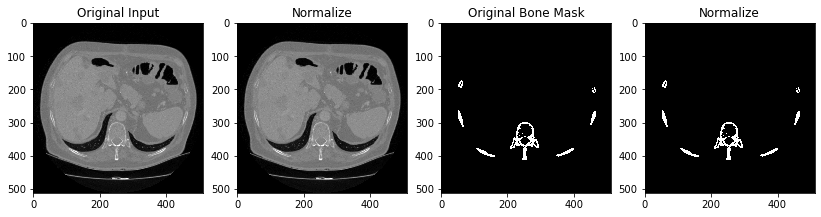

In [14]:
##########################
# Normalize Test
##########################
normalize = Normalize()
plot_transformation(normalize)

In [15]:
############################################################################################
# Create Dataset
############################################################################################
    
# Create X, y tuple from image_path, key_pts tuple
def createXy(data, transformations = None):
    
    input_image_path, bone_mask_image_path = data
    
    input_image = load_dicom(input_image_path) 
    bone_mask_image = load_dicom(bone_mask_image_path) 
    
    # Apply transformations for the tuple (image, labels, boxes)
    if transformations:
        for t in transformations:
            input_image, bone_mask_image = t(input_image, bone_mask_image)
            
    input_image = np.expand_dims(input_image, axis = -1)     
    bone_mask_image = np.expand_dims(bone_mask_image, axis = -1)            
            
    return input_image, bone_mask_image

# Generator for using with model
def generator(data, transformations = None, batch_size = 4, shuffle_data= True):
    
    n_samples = len(data)
    
    # Loop forever for the generator
    while 1:
        
        if shuffle_data:
            data = shuffle(data)
        
        for offset in range(0, n_samples, batch_size): 
            
            batch_samples = data[offset:offset + batch_size]
            
            X = []
            y = []
            
            for sample_data in batch_samples:
                
                image, target = createXy(sample_data, transformations)

                X.append(image)
                y.append(target)
                
            X = np.asarray(X).astype('float32')
            y = np.asarray(y).astype('float32')
            
            yield (shuffle(X, y))

In [17]:
############################################################################################
# Unet Model
############################################################################################
def unet_encoder(inputs,filters, block_id):
    
    x = Conv2D(filters, kernel_size=(3,3), padding='same' , kernel_initializer='he_normal', name='block_' + str(block_id) + '_unet_encoder_conv2d_1')(inputs)
    x = BatchNormalization(name='block_' + str(block_id) + '_unet_encoder_conv_batch_1')(x)
    x = Activation('relu', name='block_' + str(block_id) + '_unet_encoder_relu_1')(x)
    
    x = Conv2D(filters, kernel_size=(3,3), padding='same' , kernel_initializer='he_normal', name='block_' + str(block_id) + '_unet_encoder_conv2d_2')(x)
    x = BatchNormalization(name='block_' + str(block_id) + '_unet_encoder_conv_batch_2')(x)
    x = Activation('relu', name='block_' + str(block_id) + '_unet_encoder_relu_2')(x)
    
    return x
                
def unet_encoder_pool(inputs,filters, block_id):
    
    x = unet_encoder(inputs, filters, block_id)
    x = MaxPooling2D(pool_size=(2,2), name='block_' + str(block_id) + '_unet_pooling')(x)
    
    return x

def unet_decoder(inputs_a, inputs_b, filters, block_id):
    
    x = Conv2DTranspose(filters, kernel_size=(2,2), strides=(2,2), padding='same')(inputs_a)
    
    x = concatenate([x, inputs_b],axis=3)
    
    x = Conv2D(filters, kernel_size=(3,3), padding='same' , kernel_initializer='he_normal', name='block_' + str(block_id) + '_unet_decoder_conv2d_1')(x)
    x = BatchNormalization(name='block_' + str(block_id) + '_unet_decoder_conv_batch_1')(x)
    x = Activation('relu', name='block_' + str(block_id) + '_unet_decoder_relu_1')(x)
    
    x = Conv2D(filters, kernel_size=(3,3), padding='same' , kernel_initializer='he_normal', name='block_' + str(block_id) + '_unet_decoder_conv2d_2')(x)
    x = BatchNormalization(name='block_' + str(block_id) + '_unet_decoder_conv_batch_2')(x)
    x = Activation('relu', name='block_' + str(block_id) + '_unet_decoder_relu_2')(x)
    
    return x
              
def UNet(input_shape=(512,512,1)):
    
    Image = Input(shape=input_shape)
    
    encoder = unet_encoder_pool(Image,   filters=32,  block_id=0)
    encoder = unet_encoder_pool(encoder, filters=64,  block_id=1)
    encoder = unet_encoder_pool(encoder, filters=128, block_id=2)
    encoder = unet_encoder_pool(encoder, filters=256, block_id=3)
    encoder = unet_encoder(encoder, filters=512, block_id=4)
    
    encoder_model = Model(inputs=Image,outputs=encoder)

    tensor1 = encoder_model.get_layer('block_3_unet_encoder_relu_2').output
    tensor2 = encoder_model.get_layer('block_2_unet_encoder_relu_2').output
    tensor3 = encoder_model.get_layer('block_1_unet_encoder_relu_2').output
    tensor4 = encoder_model.get_layer('block_0_unet_encoder_relu_2').output
    
    decoder = unet_decoder(encoder, tensor1, filters=256, block_id = 4)
    decoder = unet_decoder(decoder, tensor2, filters=128, block_id = 5)
    decoder = unet_decoder(decoder, tensor3, filters=64, block_id = 6)
    decoder = unet_decoder(decoder, tensor4, filters=32, block_id = 7)
    
    decoder = Conv2D(1,kernel_size=(1,1),strides=(1,1), activation='sigmoid')(decoder)
    
    model = Model(inputs=Image, outputs=decoder)
    
    return model

############################################################################################
# Unet Loss
############################################################################################
class UNetLoss():
    
    def __init__(self, smooth = 1):
        
        self.smooth = smooth
    
    def calculate_loss(self, y_true, y_pred):
        
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        
        intersection = K.sum(y_true_f * y_pred_f)
        coefficient = (2. * intersection + self.smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + self.smooth)
        loss = 1 - coefficient
        return loss

In [18]:
############################################################################################
# Training pipeline
############################################################################################

# Data augmentation 
train_transformations = [ 
        RandomBrightness(prob=0.5),
        RandomContrast(prob=0.5),
        RandomTranslation(ratio=0.2, prob=0.5),
        RandomScale(lower=0.8,upper=1.2, prob=0.5),
        RandomFlip(prob=0.5),
        Resize((512,512),(512,512)),
        Normalize()
        ]

test_transformations = [
        RandomBrightness(prob=0.5),
        RandomContrast(prob=0.5),
        RandomTranslation(ratio=0.2, prob=0.5),
        RandomScale(lower=0.8,upper=1.2, prob=0.5),
        RandomFlip(prob=0.5),
        Resize((512,512),(512,512)),
        Normalize()
        ]

valid_transformations = [
        RandomBrightness(prob=0.5),
        RandomContrast(prob=0.5),
        RandomTranslation(ratio=0.2, prob=0.5),
        RandomScale(lower=0.8,upper=1.2, prob=0.5),
        RandomFlip(prob=0.5),
        Resize((512,512),(512,512)),
        Normalize()
        ]

# Hyperparameters
epochs = 100
batch_size = 1 # Change this value if you have more GPU Power
learning_rate = 0.001
weight_decay = 5e-4
momentum = .9

train_data, test_valid_data = train_test_split(data, test_size=0.20, random_state=42)
test_data, valid_data = train_test_split(test_valid_data, test_size=0.50, random_state=42)

print('Size of train data: {0}'.format(len(train_data)))
print('Size of test data: {0}'.format(len(test_data)))
print('Size of valid data: {0}'.format(len(valid_data)))

train_generator = generator(train_data, train_transformations, batch_size)
test_generator = generator(test_data, test_transformations, batch_size)

# callbacks
model_path = 'saved_models'

model = UNet()
model.summary()

# Create loss function
loss = UNetLoss()

# Create Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile model for training
model.compile(optimizer, loss = loss.calculate_loss, metrics=['accuracy'])

# File were the best model will be saved during checkpoint     
model_file = os.path.join(model_path,'bone_segmentation-{val_loss:.4f}.h5')

# Check point for saving the best model
check_pointer = ModelCheckpoint(model_file, monitor='val_loss', mode='min',verbose=1, save_best_only=True)

# Logger to store loss on a csv file
csv_logger = CSVLogger(filename='bone_segmentation.csv',separator=',', append=True)

Size of train data: 2258
Size of test data: 282
Size of valid data: 283
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
block_0_unet_encoder_conv2d_1 ( (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
block_0_unet_encoder_conv_batch (None, 512, 512, 32) 128         block_0_unet_encoder_conv2d_1[0][
__________________________________________________________________________________________________
block_0_unet_encoder_relu_1 (Ac (None, 512, 512, 32) 0           block_0_unet_encoder_conv_batch_1
_____________________________________

In [ ]:
history = model.fit_generator(train_generator,steps_per_epoch=int(len(train_data) / batch_size),
                              validation_data=test_generator,validation_steps=int(len(test_data) / batch_size),
                              epochs=epochs, verbose=1, callbacks=[check_pointer,csv_logger],workers=1)

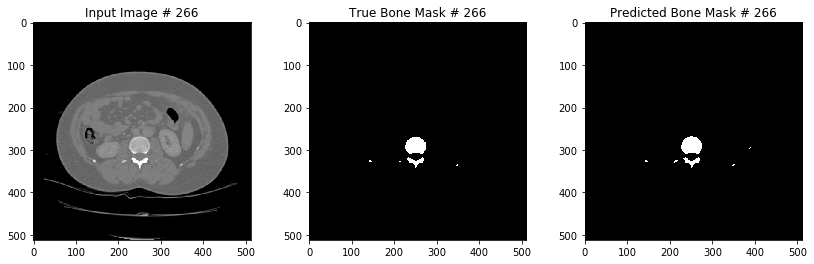

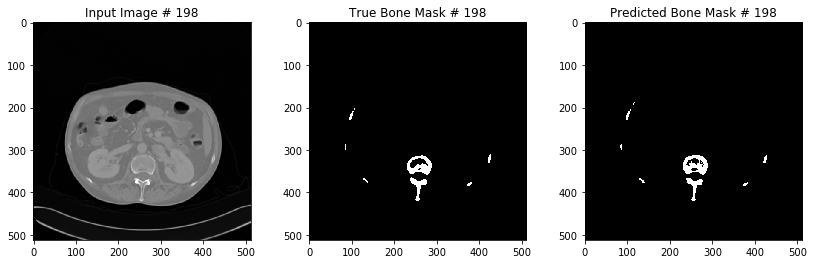

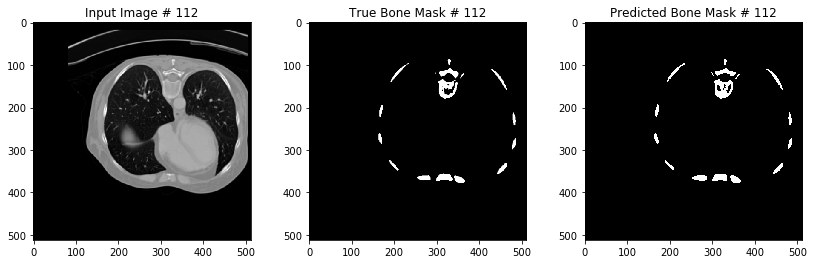

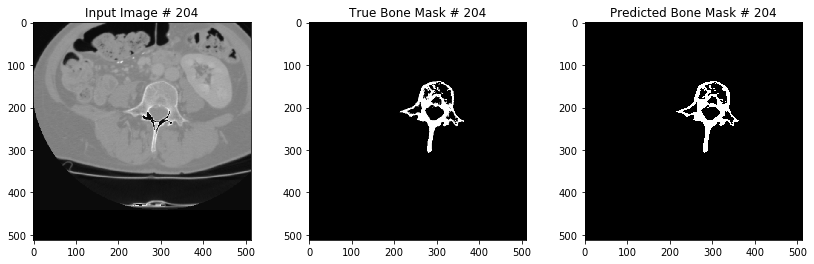

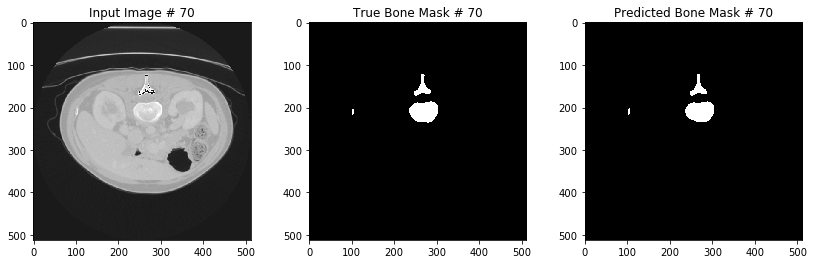

In [25]:
############################################################################################
# Predict
############################################################################################

# If we want to test on a pre trained model use the following line
#model.load_weights(os.path.join(model_path,'<path to model.h5>'), by_name=False)

n_samples = 5

for i in range(n_samples):
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    
    # randomly select a sample
    idx = np.random.randint(0, len(valid_data))
    sample = valid_data[idx]
    
    # Read input file
    input_image_path, bone_mask_image_path = sample
    
    input_image = load_dicom(input_image_path) 
    bone_mask_image = load_dicom(bone_mask_image_path) 
    
    input_image_copy = np.copy(input_image)
    bone_mask_image_copy = np.copy(bone_mask_image)

    # Apply transformations to input and background image
    for t in valid_transformations:
        input_image_copy,bone_mask_image_copy = t(input_image_copy, bone_mask_image_copy)
            
    input_image_copy = np.expand_dims(input_image_copy, axis = -1)     
    bone_mask_image_copy = np.expand_dims(bone_mask_image_copy, axis = -1)  
    
    # Predict 
    bone_mask_pred = model.predict(input_image_copy[np.newaxis,...]) 
    
     # Squeeze
    input_image_copy = np.squeeze(input_image_copy)
    bone_mask_image_copy = np.squeeze(bone_mask_image_copy)
    bone_mask_pred = np.squeeze(bone_mask_pred)

    bone_mask_pred[bone_mask_pred > 0.5] = 1
    bone_mask_pred[bone_mask_pred <= 0.5] = 0

    # Plot 
    ax1.set_title('Input Image # {0}'.format(idx))
    ax1.imshow(input_image_copy , cmap='gray')
    
    ax2.set_title('True Bone Mask # {0}'.format(idx))
    ax2.imshow(bone_mask_image_copy, cmap='gray')
    
    ax3.set_title('Predicted Bone Mask # {0}'.format(idx))
    ax3.imshow(bone_mask_pred, cmap='gray')

--------------------------------------------------
Recal: Avg:0.95 , Max: 1.00 , Min: 0.00
--------------------------------------------------
Precision: Avg:0.96 , Max: 1.00 , Min: 0.00
--------------------------------------------------
False Positive Rate: Avg:0.00 , Max: 0.01 , Min: 0.00
--------------------------------------------------
Calculate False Negative Rate: Avg:0.05 , Max: 1.00 , Min: 0.00
--------------------------------------------------
Percentage of Wrong Classifications: Avg:0.14 , Max: 1.17 , Min: 0.01
--------------------------------------------------
Jaccard: Avg:0.92 , Max: 0.99 , Min: 0.00
--------------------------------------------------
Dice: Avg:0.96 , Max: 1.00 , Min: 0.00
--------------------------------------------------
--------------------------------------------------
Confusion Matrix
--------------------------------------------------


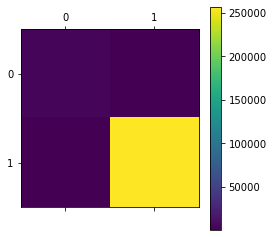

In [22]:
############################################################################################
# Evaluate our model
############################################################################################

measures = np.zeros((len(data),11))
statistics = []
    
for i, sample in enumerate(data):
    
    # Retrieve tuple
    input_image_path, bone_mask_image_path= sample
    
    print("input: {0} , gt: {1}".format(input_image_path.split("\\")[-1], bone_mask_image_path.split("\\")[-1]))
    
    # Read input file
    input_image = load_dicom(input_image_path) 
    bone_mask_image = load_dicom(bone_mask_image_path) 
    
    # Make a copy for safety
    input_image_copy = np.copy(input_image)
    bone_mask_image_copy = np.copy(bone_mask_image)
    
    # Apply transformations to input and background image. This time we will not use the ground truth image 
    # in the transformation step since we want to evaluate against the original data excluding the mask
    # Apply transformations to input and background image
    for t in valid_transformations:
        input_image_copy,bone_mask_image_copy = t(input_image_copy, bone_mask_image_copy)

    # Correct single dimensions
    input_image_copy = np.expand_dims(input_image_copy, axis = -1)     
    bone_mask_image_copy = np.expand_dims(bone_mask_image_copy, axis = -1)  
    
    # Predict 
    bone_mask_pred = model.predict(input_image_copy[np.newaxis,...]) 
    
     # Squeeze
    input_image_copy = np.squeeze(input_image_copy)
    y_true = np.squeeze(bone_mask_image_copy)
    y_pred = np.squeeze(bone_mask_pred)
    
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    plt.imsave('dataset\\processed\\inputs\\' + input_image_path.split("\\")[-1].split('.')[0] + ".jpg" , input_image_copy, cmap='gray')
    plt.imsave('dataset\\processed\\masks\\' + bone_mask_image_path.split("\\")[-1].split('.')[0] + ".jpg" , y_true, cmap='gray')
    plt.imsave('dataset\\processed\\preds\\' + bone_mask_image_path.split("\\")[-1].split('.')[0] + ".jpg" , y_pred, cmap='gray')
        
    # Calculate True Positive, True Negative, False Positive, False Negative
    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))

    # Calculate Recall
    recall = TP / (TP + FN)
    
    # Calculate Precision
    precision =  TP / (TP + FP)
    
    # Calculate Recall
    Dice = 2 * TP / (2 * TP + FP + FN)
    
    # Calculate Specificity
    Jaccard = Dice / (2 - Dice)

    # Calculate False Positive Rate
    FPR =  FP / (FP + TN)
    
    # Calculate False Negative Rate
    FNR = FN / (TP + FN)
    
    # Calculate Percentage of Wrong Classifications
    PWC =  100 * (FN + FP) / (TP + FN + FP + TN)

    stats = { 'input_image': input_image_path,
              'bone_mask_image' : bone_mask_image_path,
              'TP' : TP,
              'TN' : TN,
              'FP' : FP,
              'FN' : FN,
              'recall' : recall,
              'precision' : precision,
              'FPR' : FPR,
              'FNR' : FNR,
              'PWC' : PWC,
              'Jaccard' : Jaccard,
              'Dice' : Dice
            }
    
    statistics.append(stats)
    
    measures[i][0] = TP
    measures[i][1] = TN
    measures[i][2] = FP
    measures[i][3] = FN
    measures[i][4] = recall
    measures[i][5] = precision
    measures[i][6] = FPR
    measures[i][7] = FNR
    measures[i][8] = PWC
    measures[i][9] = Jaccard
    measures[i][10] = Dice

# Replace NaN by zeros
measures[np.isnan(measures)] = 0

# Calculate Mean Average for all our statistics
mean_score = measures.mean(axis=0)
max_score = measures.max(axis=0)
min_score = measures.min(axis=0)

# Print Average Statistics
print(50*'-')
print('Recal: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[4],max_score[4],min_score[4]))
print(50*'-')
print('Precision: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[5],max_score[5],min_score[5]))
print(50*'-')
print('False Positive Rate: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[6],max_score[6],min_score[6]))
print(50*'-')
print('Calculate False Negative Rate: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[7],max_score[7],min_score[7]))
print(50*'-')
print('Percentage of Wrong Classifications: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[8],max_score[8],min_score[8]))
print(50*'-')
print('Jaccard: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[9],max_score[9],min_score[9]))
print(50*'-')
print('Dice: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[10],max_score[10],min_score[10]))
print(50*'-')

# Create Confusion Matrix
cm = np.zeros((2,2))
cm[0][0] = mean_score[0]
cm[0][1] = mean_score[2]
cm[1][0] = mean_score[3]
cm[1][1] = mean_score[1]

print(50*'-')
print('Confusion Matrix')
plt.matshow(cm)
plt.colorbar()
print(50*'-')

# Save results on a file
results_folder = 'results'

# Create Dataset folder 
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    
csv_columns = ['input_image','bone_mask_image','TP','TN','FP','FN','recall','precision','FPR','FNR','PWC','Jaccard','Dice']

csv_file = os.path.join(results_folder, 'bone_segmentation_stats.csv')

try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns, lineterminator = '\n')
        writer.writeheader()
        for data in statistics:
            writer.writerow(data)
except IOError:
    print("I/O error") 

After training and testing the model I used in a dataset provided for our university that I believe belongs to the VOXEL-MAN project that can be found on the following link.
https://www.voxel-man.com/segmented-inner-organs-of-the-visible-human/

![Hamburg University SIO Database](images/bone_segmentation.gif)